- check uncertainty implementation done
- safe best model done
- try and optimize neural networks done
- check error measurement done
- uncertainty quantification, parameter distribution
- try with normalized data
- pipeline aufstellen
- individual errors for forecast horizon maybe not necessary
- predict entirely new data from same time series
- plot losses
- plot prediction error



# Imports


In [ ]:
pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 10.8 MB/s eta 0:00:00


In [ ]:
pip install yfinance

In [ ]:
 pip install scipy

In [ ]:
#imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from PIL import Image
from torch.utils.data.dataset import Dataset
import scipy
import torch.nn.functional as nnf
from torch.optim import SGD
from pyro.infer import MCMC, NUTS

In [ ]:
import pyro
from pyro.distributions import Normal, Categorical
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
import yfinance as yf
import matplotlib.pyplot as plt
import time
import fastprogress
import seaborn as sns
from pyro.nn import PyroModule, PyroSample
from sklearn.model_selection import train_test_split
import pyro.distributions as dist
from pyro.nn import PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.infer.autoguide import AutoDiagonalNormal
from tqdm.auto import trange
from pyro.infer import Predictive
from matplotlib import pyplot as plt
import numpy as np
from google.colab import files

In [ ]:
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix >= len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


def multi_time(data, n_input, n_out):

    X,y = list(), list()
    in_start= 0

    for i in range(len(data)):

        in_end = in_start + n_input
        out_end = in_end + n_out
        if out_end <= len(data):
            X.append(data[in_start:in_end])
            y.append(data[in_end:out_end])
            in_start +=1
    return np.array(X), np.array(y)


In [ ]:
class myDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target

    def __len__(self):
        return len(self.feature)

    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]

        return item,label


In [ ]:
def plot_results(inputs, test_y, prediction, plus_error, minus_error, title = None, x_train = None):
  plt.rcParams["figure.figsize"] = (18, 10)
  x = np.arange(1, len(test_y)+1)

  plt.plot(x, test_y, label='Truth')
  plt.plot(x, prediction, label='Prediction')

  plt.fill_between(x, plus_error, minus_error, color='gray', alpha=0.5)

  if x_train is not None:
    plt.axvline(x=len(x_train), linestyle='--', color='r', label='Train-Test Split')

  plt.xlabel('Months')
  plt.ylabel('Index')
  plt.title(title)
  plt.legend()

  plt.show()

In [ ]:
def rmse(test_data, prediction):
  mse = ((test_data - prediction)**2).sum()/len(prediction)
  return np.sqrt(mse)

In [ ]:
def mape(test_data, prediction):
  mape = abs((test_data-prediction)/test_data).sum()/len(prediction)
  return mape

#Data and data processing

In [ ]:
df = yf.download('^SPGSCI', start="2010-09-23", end="2024-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']

[*********************100%%**********************]  1 of 1 completed


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

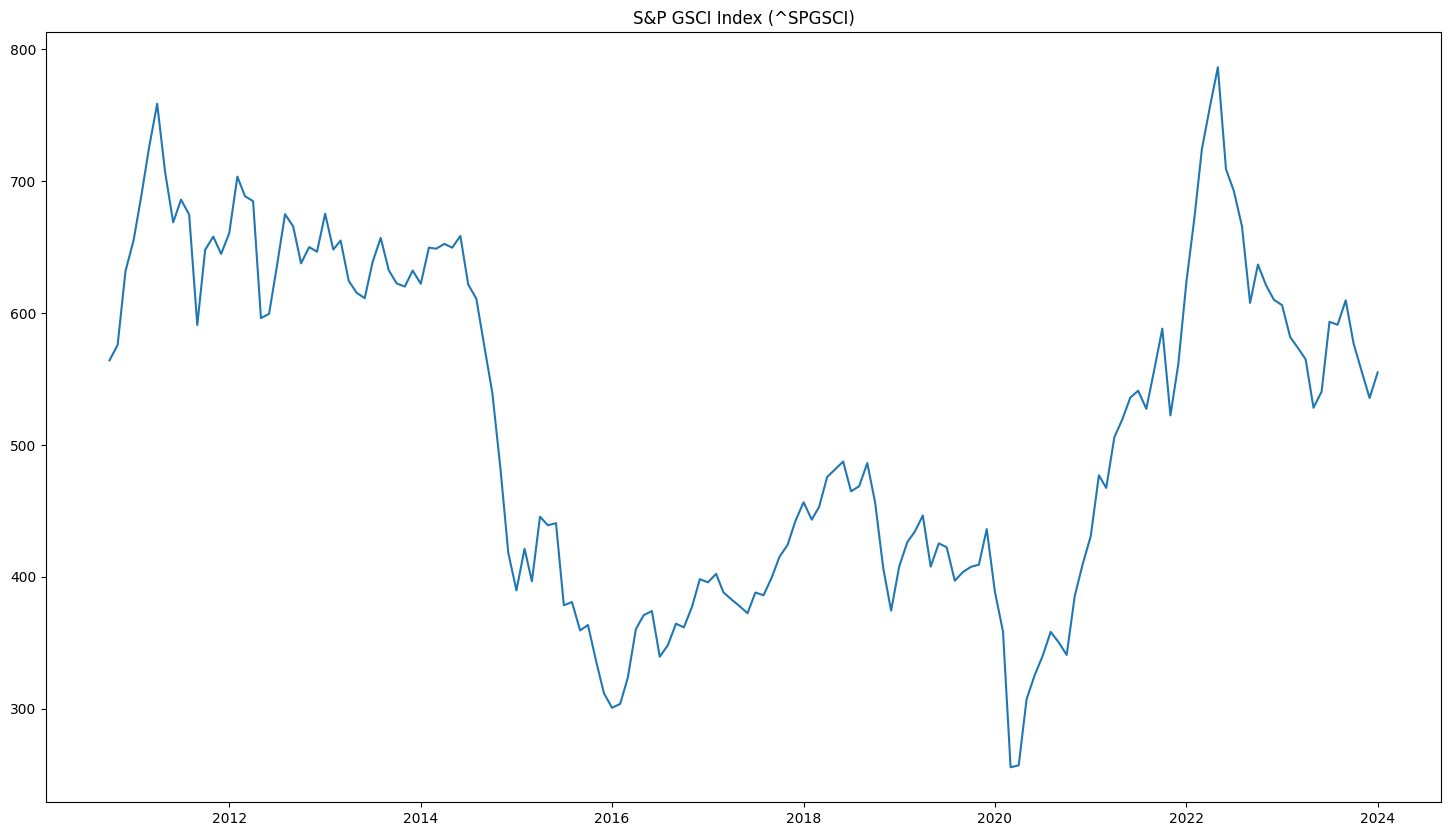

In [ ]:
plt.rcParams["figure.figsize"] = (18, 10)
plt.plot(df.loc[:,'Adj Close'])
plt.title('S&P GSCI Index (^SPGSCI)')
plt.savefig("Index.png")
files.download("Index.png")

In [ ]:
print(f"Low:{df.loc[:,'Adj Close'].min()}")
print(f"Mean:{df.loc[:,'Adj Close'].mean()}")
print(f"High:{df.loc[:,'Adj Close'].max()}")
print(f"Standard Deviation:{df.loc[:,'Adj Close'].std()}")

Low:255.5399932861328
Mean:515.3525631904602
High:786.4500122070312
Standard Deviation:128.0368466451445


In [ ]:
data_list = []
data_test_list = []

data = data_close.values
test_data = data
data = data[:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)
#data_norm = (dataset - min(dataset)) / (max(dataset)-min(dataset))

# One_step CNN

In [ ]:
train_x,train_y= split_sequences(dataset, 3)
test_x, test_y = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(train_x.reshape(train_x.shape[0],train_x.shape[1],1)).float()
y_train = torch.tensor(train_y.reshape(train_y.shape[0],1,1)).float()
x_test = torch.tensor(test_x.reshape(test_x.shape[0],test_x.shape[1],1)).float()
y_test = torch.tensor(test_y.reshape(test_y.shape[0],1,1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_onestep_cnn(PyroModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = PyroModule[nn.Conv1d](in_channels = 3, out_channels = 6, kernel_size = 2, padding = 'same')
        self.activation = PyroModule[nn.ReLU]()
        self.layer_2 = PyroModule[nn.Conv1d](6, 12, 2, padding='same')
        self.linear_1 = PyroModule[nn.Linear](12,1)

        self.pool = nn.MaxPool1d(kernel_size=2, padding = 1)

        self.layer_1.weight = PyroSample(dist.Normal(0, 1).expand([6,3,2]).to_event(3))
        self.layer_1.bias = PyroSample(dist.Normal(0, 1).expand([6]).to_event(1))
        self.layer_2.weight = PyroSample(dist.Normal(0, 1).expand([12,6,2]).to_event(3))
        self.layer_2.bias = PyroSample(dist.Normal(0, 1).expand([12]).to_event(1))
        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([1,12]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y = None):

        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
pyro.clear_param_store()
model_cnn_one = BNN_onestep_cnn()
guide_model_cnn_one = AutoDiagonalNormal(model_cnn_one)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model_cnn_one, guide_model_cnn_one, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 3000
progress_bar = trange(num_epochs)


loss_best = None

for epoch in progress_bar:
    loss=0
    for batch_id, data in enumerate(train_loader):
      loss += svi.step(data[0], data[1])

    if loss_best is None or loss < loss_best:
      loss_best = loss
      torch.save({"model" : model_cnn_one.state_dict(), "guide" : guide_model_cnn_one}, "cnn_one.pt")
      pyro.get_param_store().save("cnn_one_params.pt")

    progress_bar.set_postfix(loss=f"{loss / len(x_train):.3f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1008.)
  return F.conv1d(input, weight, bias, self.stride,


In [ ]:
saved_cnn_one= torch.load("cnn_one.pt")
model_cnn_one.load_state_dict(saved_cnn_one['model'])
guide_cnn_one = saved_cnn_one['guide']
pyro.get_param_store().load("cnn_one_params.pt")

In [ ]:

predictive = Predictive(model_cnn_one, guide = guide_cnn_one, num_samples=500)
pred_cnn_one= []
plus_error_cnn_one = []
minus_error_cnn_one = []
covariance_cnn_one = []

for batch_id, data in enumerate(test_loader):
        preds = predictive(data[0])
        y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
        y_preds = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500
        plus_error_cnn_one.append(y_preds - 2* y_std)
        minus_error_cnn_one.append(y_preds + 2* y_std)
        pred_cnn_one.append(y_preds)
        covariance = ((preds['obs'][:,0,:].detach().numpy() - y_preds)**2).sum()/499
        covariance_cnn_one.append(covariance)


In [ ]:
len(covariance_cnn_one)

157

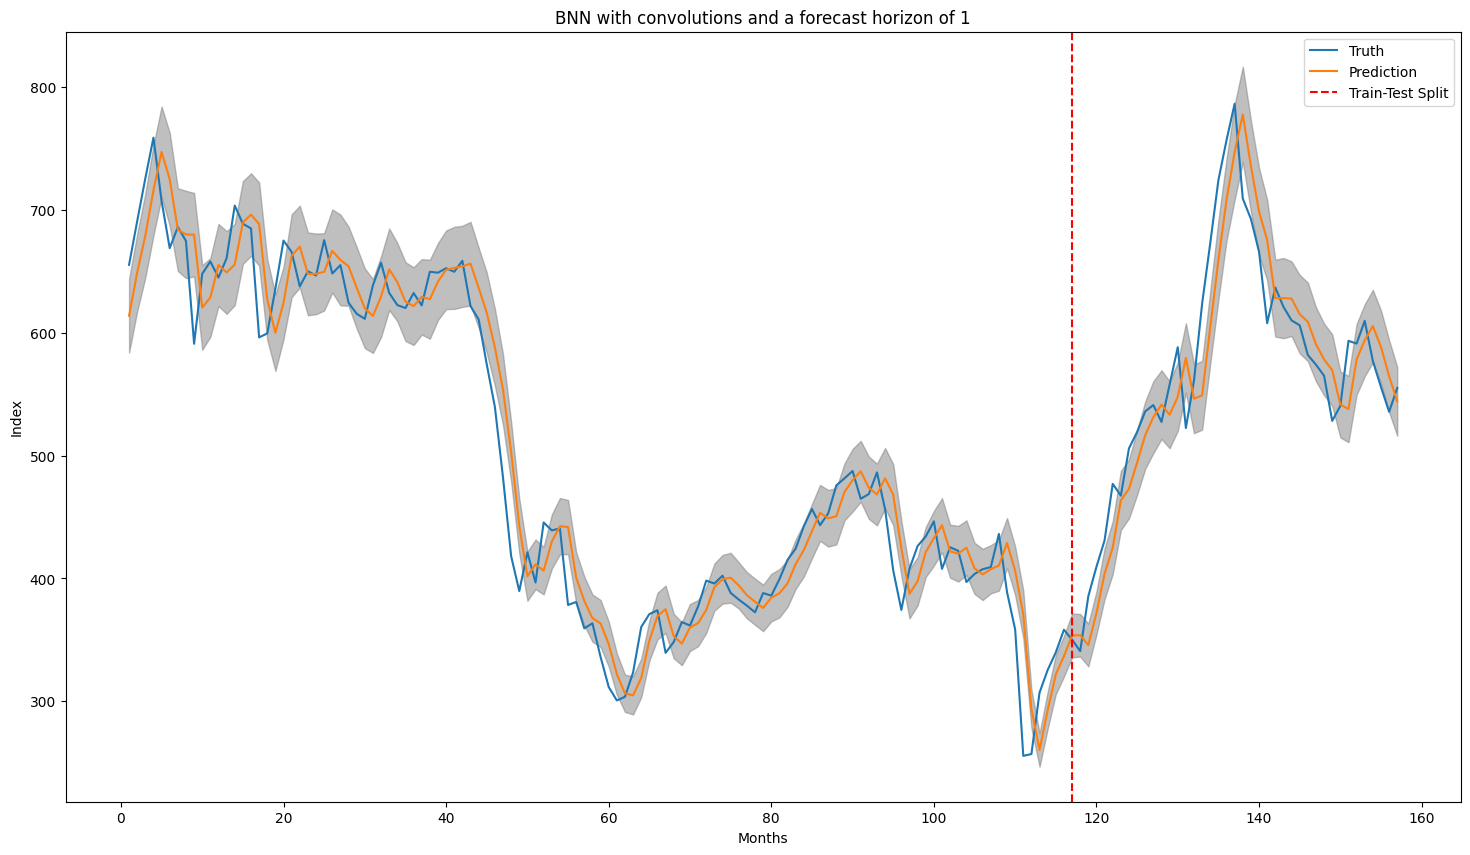

In [ ]:
plot_results(3, test_y, pred_cnn_one, np.vstack(plus_error_cnn_one).squeeze().tolist(),
             np.vstack(minus_error_cnn_one).squeeze().tolist(), title = 'BNN with convolutions and a forecast horizon of 1', x_train = x_train)

In [ ]:
nssr = [(pred_cnn_one[i]-test_y[i])*(1/covariance_cnn_one[i])*(pred_cnn_one[i]-test_y[i]) for i in range(157)]

In [ ]:
import scipy.stats as stats

def chi_square_cdf_probabilities(nssr):
    """
    Compute the probabilities of the values of nssr under a chi-square CDF with 1 dof.

    Parameters:
        nssr (float or array-like): Non-centrality parameter(s).

    Returns:
        float or ndarray: Probability value(s).
    """
    return stats.chi2.cdf(nssr, df=1)

predicted_probability = chi_square_cdf_probabilities(nssr)
print(predicted_probability)

[[0.99438244]
 [0.99219498]
 [0.99353549]
 [0.98067637]
 [0.96997453]
 [0.99692369]
 [0.10193861]
 [0.23488412]
 [0.99999983]
 [0.88988113]
 [0.93327537]
 [0.4599655 ]
 [0.51089097]
 [0.99626805]
 [0.0479303 ]
 [0.49975117]
 [0.99999995]
 [0.90793049]
 [0.97932594]
 [0.99943451]
 [0.14493998]
 [0.94837942]
 [0.10142298]
 [0.06419513]
 [0.89899077]
 [0.72340392]
 [0.17879528]
 [0.93499442]
 [0.79775923]
 [0.4033513 ]
 [0.90308517]
 [0.90830114]
 [0.75526486]
 [0.75901519]
 [0.25498966]
 [0.49887354]
 [0.34831917]
 [0.83586546]
 [0.35326249]
 [0.06349878]
 [0.1495012 ]
 [0.21615396]
 [0.95739129]
 [0.88706588]
 [0.9900588 ]
 [0.99812389]
 [0.99999937]
 [1.        ]
 [0.99999809]
 [0.94928073]
 [0.85834461]
 [0.99995094]
 [0.59092475]
 [0.12515427]
 [0.99999999]
 [0.94521684]
 [0.97604811]
 [0.33851229]
 [0.99565652]
 [0.99986624]
 [0.9893808 ]
 [0.29194688]
 [0.98347299]
 [0.99999988]
 [0.99189901]
 [0.38064849]
 [0.9997726 ]
 [0.40765426]
 [0.95539995]
 [0.12675506]
 [0.85216867]
 [0.98

In [ ]:

def count_elements_bigger_than_p(vector, p):
    """
    Count the number of elements in the vector that are bigger than p.

    Parameters:
        vector (list): The input vector.
        p (float): The value to compare against.

    Returns:
        int: Number of elements in the vector that are bigger than p.
    """
    return sum(1 for x in vector if x <= p)


observed_probability = [count_elements_bigger_than_p(nssr,p)/len(nssr) for p in nssr]

In [ ]:
p_array = np.column_stack((predicted_probability, observed_probability))
curve = np.row_stack(([0,0],(p_array[p_array[:, 0].argsort()])))


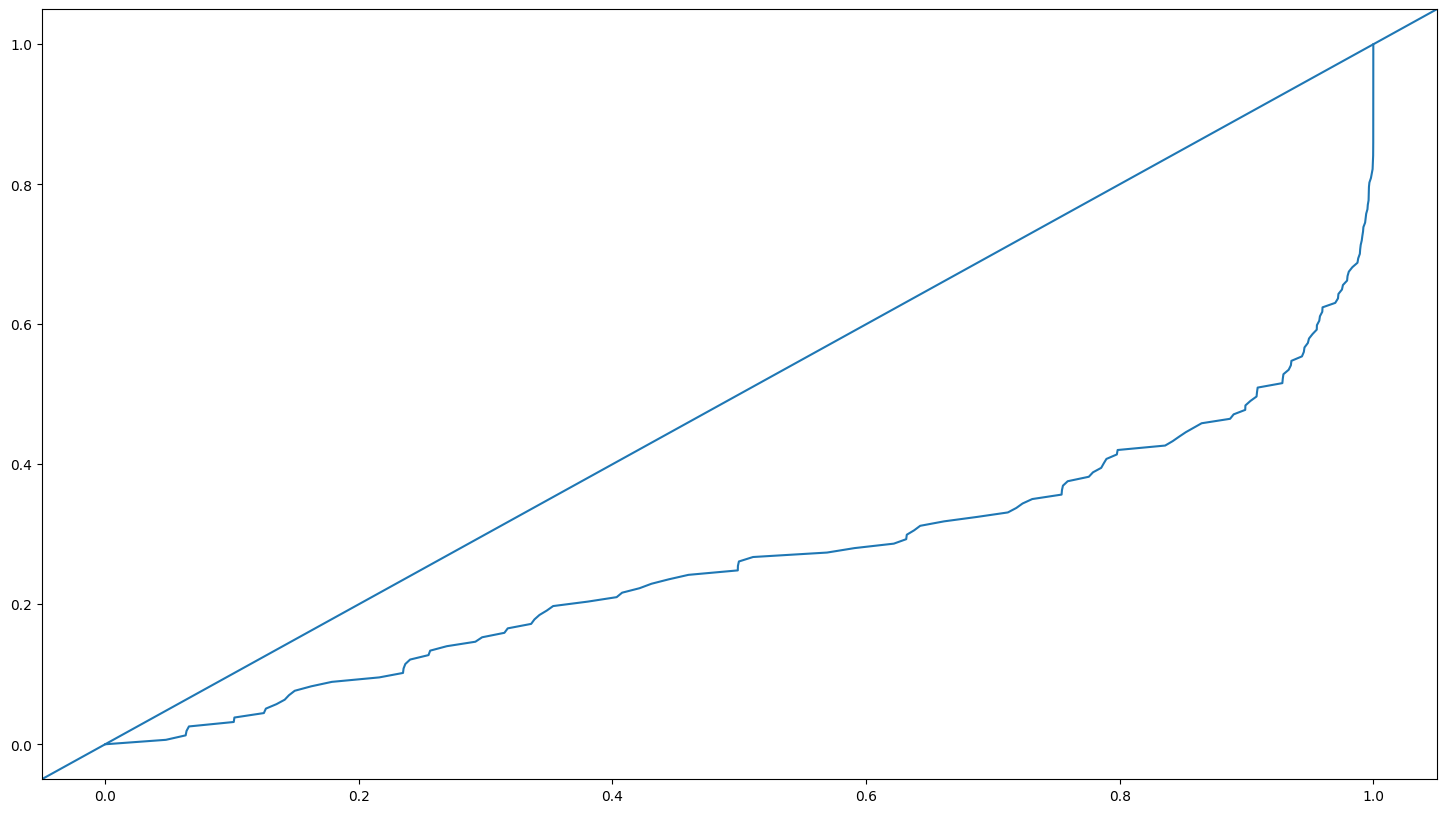

In [ ]:
plt.plot(curve[:,0], curve[:,1])
plt.axline([0, 0], [1, 1])

In [ ]:
np.mean(observed_probability)

from sklearn.metrics import auc

auc(curve[:,0], curve[:,1])

0.2610118561528605

In [ ]:
np.sqrt(auc(curve[:,0],(curve[:,1]-curve[:,0])**2))

0.27129898546701775

In [ ]:

#.mean(axis=1)

mse_model = ((test_y.flatten()-np.concatenate(pred_cnn_one, axis =0))**2).sum()/len(pred_cnn_one)

print(np.sqrt(mse_model))

print(rmse(test_y.flatten(),np.concatenate(pred_cnn_one, axis =0)))
print(mape(test_y.flatten(),np.concatenate(pred_cnn_one, axis =0)))


33.11732907877412
33.11732907877412
0.05280770234631219


#BNN Autoencode


In [ ]:
class Encode_BNN(PyroModule):
  def __init__(self, in_channels=3, out_channels=3, latent_dim=100, act_fn=nn.ReLU()):
    super().__init__()
    assert in_dim > 0 and out_dim > 0
        #self.layer_sizes = [in_dim] + n_hid_layers * [hid_dim] + [out_dim]

    self.net= nn.Sequential(
        nn.Conv1d(in_channels, out_channels, 2, padding=1),
        act_fn,
        nn.Conv1d(out_channels, out_channels, 2, padding=1),
        act_fn,
        nn.Conv1d(out_channels, 2*out_channels, 2, padding=1, stride=2),
        act_fn,
        nn.Conv1d(2*out_channels, 2*out_channels, 2, padding=1),
        act_fn,
        nn.Conv1d(2*out_channels, 4*out_channels, 2, padding=1, stride=2),
        Pact_fn,
        nn.Conv1d(4*out_channels, 4*out_channels, 2, padding=1),
        act_fn,
        nn.Flatten(),
        nn.Linear(4*out_channels, latent_dim),
        act_fn
        )


    to_pyro_module_(self.net)
    assert isinstance(self.net, PyroModule[nn.Sequential])

    for m in self.net.modules():
      for name, value in list(m.named_parameters(recurse=False)):
        setattr(m, name, PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))


  def forward(self, x, y = None):

      output= self.net(x)


class Decode_BNN(PyroModule):
    def __init__(self, in_channels=3, out_channels=16, latent_dim=200, act_fn=nn.ReLU()):
    super().__init__()

    self.out_channels = out_channels

    self.conv = nn.Sequential(
        nn.Linear(latent_dim, 4*out_channels),
        act_fn
        nn.ConvTranspose1d(4*out_channels, 4*out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose1d(4*out_channels, 2*out_channels, 3, padding=1,
                           stride=2, output_padding=1),
        act_fn,
        nn.ConvTranspose1d(2*out_channels, 2*out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose1d(2*out_channels, out_channels, 3, padding=1,
                           stride=2, output_padding=1),
        act_fn,
        nn.ConvTranspose1d(out_channels, out_channels, 3, padding=1),
        act_fn,
        nn.ConvTranspose1d(out_channels, in_channels, 3, padding=1)
      )

    to_pyro_module_(self.conv)
        assert isinstance(self.conv, PyroModule[nn.Sequential])

    for m in self.conv.modules():
        for name, value in list(m.named_parameters(recurse=False)):
          setattr(m, name, PyroSample(prior=dist.Normal(0, 1).expand(value.shape).to_event(value.dim())))


  def forward(self, x):

    output = self.conv(output)
    return output

class Autoencoder(PyroModule):
  def __init__(self, encoder, decoder):
  super().__init__()
  self.encoder = encoder
  self.decoder = decoder


  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


# Multi step CNN



In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2024-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x,train_y= multi_time(dataset, 3, 3)
test_x, test_y = multi_time(data_test_set, 3, 3)

In [ ]:
y_test = test_y[::3]
x_test = test_x[::3]
x_train = train_x[::3]
y_train = train_y[::3]

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],y_train.shape[1],1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],y_train.shape[1],1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_multistep_cnn(PyroModule):
    def __init__(self):
        super().__init__()
        assert in_dim > 0 and out_dim > 0
        self.layer_1 = PyroModule[nn.Conv1d](in_channels = 3, out_channels = 6, kernel_size = 2, padding = 'same')
        self.activation = PyroModule[nn.ReLU]()
        self.layer_2 = PyroModule[nn.Conv1d](6, 12, 2, padding='same')
        self.linear_1 = PyroModule[nn.Linear](12,3)

        self.layer_1.weight = PyroSample(dist.Normal(0, 1).expand([6,3,2]).to_event(3))
        self.layer_1.bias = PyroSample(dist.Normal(0, 1).expand([6]).to_event(1))
        self.layer_2.weight = PyroSample(dist.Normal(0, 1).expand([12,6,2]).to_event(3))
        self.layer_2.bias = PyroSample(dist.Normal(0, 1).expand([12]).to_event(1))
        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([3,12]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([3]).to_event(1))

    def forward(self, x, y = None):

        x = self.activation(self.layer_1(x))
        x = self.activation(self.layer_2(x))
        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
pyro.clear_param_store()

model_cnn_multi = BNN_multistep_cnn()
mean_field_guide_cnn_multi = AutoDiagonalNormal(model_cnn_multi)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model_cnn_multi, mean_field_guide_cnn_multi, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 5000
progress_bar = trange(num_epochs)

loss_best = None

for epoch in progress_bar:
    loss = 0
    for batch_id, data in enumerate(train_loader):
        loss += svi.step(data[0], data[1])
    if loss_best is None or loss < loss_best:
      loss_best = loss
      torch.save({"model" : model_cnn_multi.state_dict(), "guide" : mean_field_guide_cnn_multi}, "cnn_multi.pt")
      pyro.get_param_store().save("cnn_multi_params.pt")

    progress_bar.set_postfix(loss=f"{loss / len(x_train):.3f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

IndexError: index 13 is out of bounds for dimension 0 with size 13

In [ ]:
saved_cnn_multi = torch.load("cnn_multi.pt")
model_cnn_multi.load_state_dict(saved_cnn_multi['model'])
guide_cnn_multi = saved_cnn_multi['guide']
pyro.get_param_store().load("cnn_multi_params.pt")

FileNotFoundError: [Errno 2] No such file or directory: 'mymodel_multi_cnn.pt'

In [ ]:
predictive = Predictive(model_cnn_multi, guide = guide_cnn_multi, num_samples=500)
pred_cnn_multi = []
plus_error_cnn_multi = []
minus_error_cnn_multi = []

for batch_id, data in enumerate(test_loader):
        preds = predictive(data[0])
        y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
        y_preds = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500
        plus_error_cnn_multi.append(y_preds - 2* y_std)
        minus_error_cnn_multi.append(y_preds + 2* y_std)
        pred_cnn_multi.append(y_preds)

ValueError: x and y must have same first dimension, but have shapes (156,) and (157,)

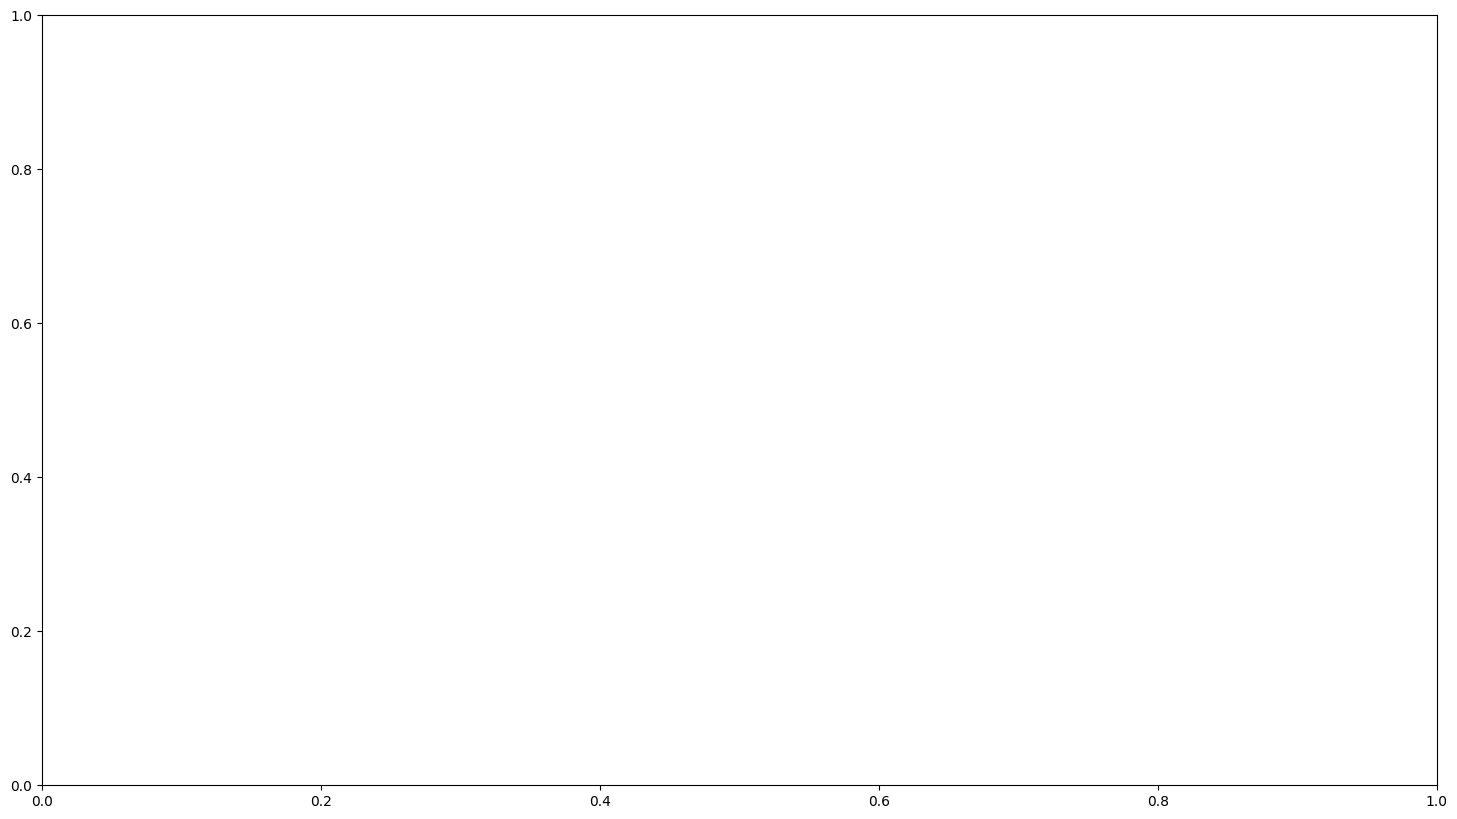

In [ ]:
plt.rcParams["figure.figsize"] = (18, 10)
x = np.arange(1, 157)

plt.plot(x,test_y.flatten(), label='Truth')
plt.plot(x, np.concatenate(pred_cnn, axis=0).flatten(), label='Prediction')

plt.fill_between(x, np.array(plus_error_cnn).squeeze().flatten(),np.array(minus_error_cnn).squeeze().flatten(), color='gray', alpha=0.5)
plt.axvline(x=120, linestyle='--', color='r', label='Test Set')

plt.xlabel('Months')
plt.ylabel('Index')
plt.title('Multistep with Convolutions')
plt.legend()

plt.show()

In [ ]:
mse_model = ((test_y.flatten()-np.concatenate(pred_cnn, axis =0))**2).sum()/len(pred_cnn)

print(np.sqrt(mse_model))

86.86901260781457


# One-step Linear

In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2024-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x,y_train= split_sequences(dataset, 3)
test_x, test_y = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(train_x.reshape(train_x.shape[0],train_x.shape[1],1)).float()
y_train = torch.tensor(train_y.reshape(train_y.shape[0],1,1)).float()
x_test = torch.tensor(test_x.reshape(test_x.shape[0],test_x.shape[1],1)).float()
y_test = torch.tensor(test_y.reshape(test_y.shape[0],1,1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_onestep(PyroModule):
    def __init__(self):
        super().__init__()
        assert in_dim > 0 and out_dim > 0
        self.linear_1 = PyroModule[nn.Linear](3,10)
        self.activation = PyroModule[nn.ReLU]()
        self.linear_2 = PyroModule[nn.Linear](10,30)
        self.linear_3 = PyroModule[nn.Linear](30,1)

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([1,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
pyro.clear_param_store()

model_linear_one = BNN_linear_onestep()
mean_field_guide_linear_one = AutoDiagonalNormal(model_linear_one)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model_linear_one, mean_field_guide_linear_one, optimizer, loss=Trace_ELBO())

num_epochs = 3000
progress_bar = trange(num_epochs)

loss_best = None

for epoch in progress_bar:
    loss = 0
    for batch_id, data in enumerate(train_loader):
        loss += svi.step(data[0], data[1])

    if loss_best is None or loss < loss_best:
      loss_best = loss
      torch.save({"model" : model_linear_one.state_dict(), "guide" : mean_field_guide_linear_one}, "linear_one.pt")
      pyro.get_param_store().save("linear_one_params.pt")

    progress_bar.set_postfix(loss=f"{loss / len(x_train):.3f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
saved_linear_one = torch.load("linear_one.pt")
guide_linear_one = saved_linear_one['guide']
model_linear_one.load_state_dict(saved_linear_one['model'])
pyro.get_param_store().load("linear_one_params.pt")

In [ ]:

predictive = Predictive(model_linear_one, guide = guide_linear_one, num_samples=500)
#preds = predictive(x_test)
pred_linear_one = []
plus_error_linear_one = []
minus_error_linear_one = []

for batch_id, data in enumerate(test_loader):
        preds = predictive(data[0])
        y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
        y_preds = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500
        plus_error_linear_one.append(y_preds - 2* y_std)
        minus_error_linear_one.append(y_preds + 2* y_std)
        pred_linear_one.append(y_preds)

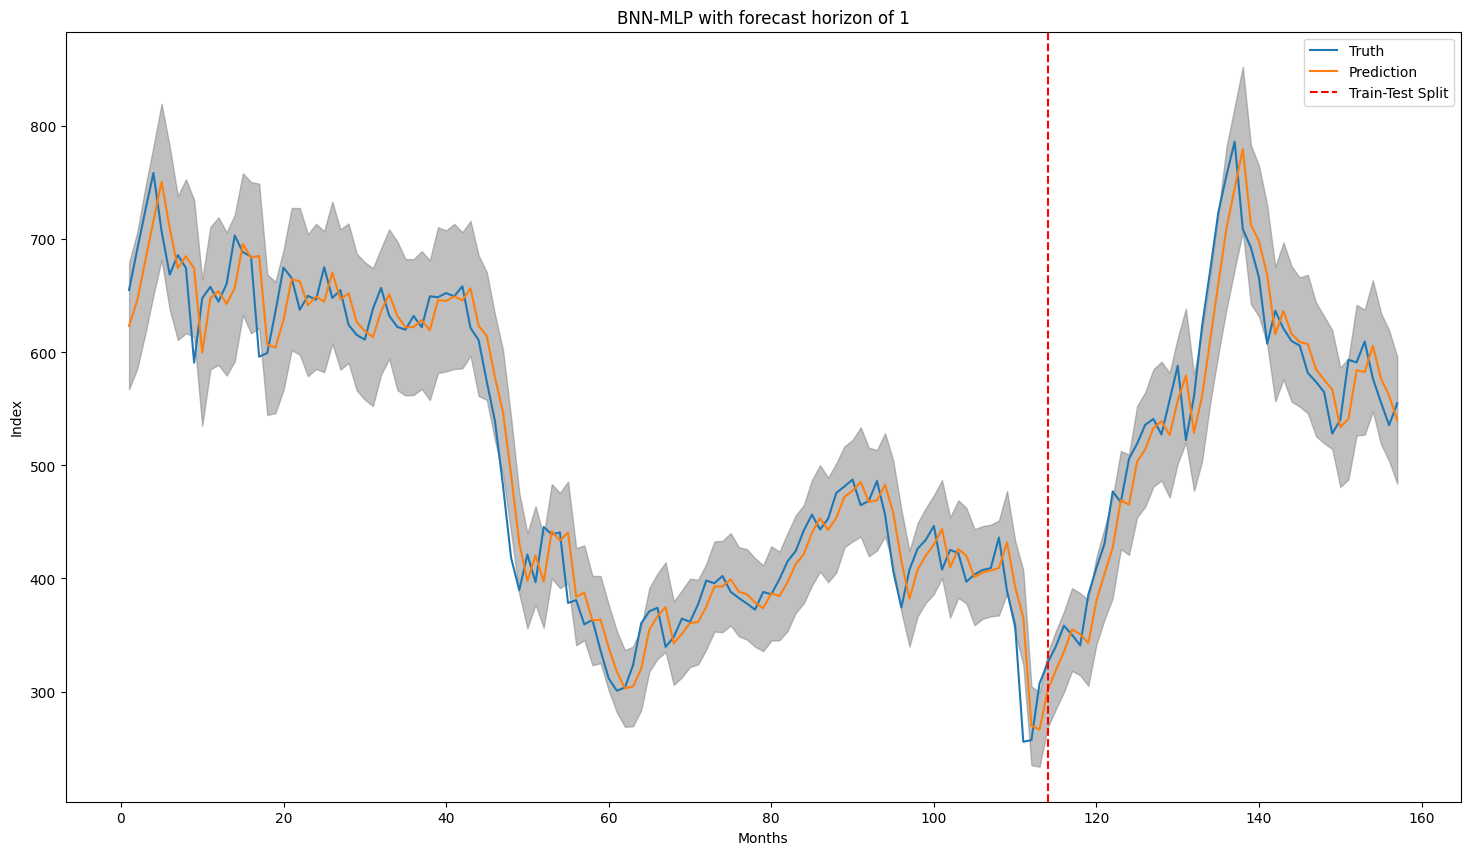

In [ ]:
plot_results(3, test_y, pred_cnn, np.vstack(plus_error).squeeze().tolist(),
             np.vstack(minus_error).squeeze().tolist(), 'BNN-MLP with forecast horizon of 1', x_train)

In [ ]:
mse_model = ((torch.cat(real).numpy().squeeze()-np.concatenate(pred_cnn, axis =0))**2).sum()/len(pred_cnn)

print(np.sqrt(mse_model), np.sqrt(mse_naive))

NameError: name 'real' is not defined

# Multi_step_linear


In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2024-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x, train_y= multi_time(dataset, 3, 3)
test_x, test_y = multi_time(data_test_set, 3, 3)

In [ ]:
y_test = test_y[::3]
x_test = test_x[::3]
x_train = train_x[::3]
y_train = train_y[::3]

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],y_train.shape[1],1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],y_test.shape[1],1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_multistep(PyroModule):
    def __init__(self):
        super().__init__()
        assert in_dim > 0 and out_dim > 0
        self.linear_1 = PyroModule[nn.Linear](3,10)
        self.activation = PyroModule[nn.ReLU]()
        self.linear_2 = PyroModule[nn.Linear](10,30)
        self.linear_3 = PyroModule[nn.Linear](30,3)

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([3,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([3]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:

pyro.clear_param_store()

model_linear_multi= BNN_linear_multistep()
mean_field_guide_linear_multi = AutoDiagonalNormal(model_linear_multi)
optimizer = pyro.optim.Adam({"lr": 0.01})

svi = SVI(model_linear_multi, mean_field_guide_linear_multi, optimizer, loss=Trace_ELBO())
pyro.clear_param_store()

num_epochs = 5000
progress_bar = trange(num_epochs)

loss_best = None

for epoch in progress_bar:
    loss = 0
    for batch_id, data in enumerate(train_loader):
        loss += svi.step(data[0], data[1])
    if loss_best is None or loss < loss_best:
      loss_best = loss
      torch.save({"model" : model_linear_multi.state_dict(), "guide" : mean_field_guide_linear_multi}, "linear_multi.pt")
      pyro.get_param_store().save("linear_multi_params.pt")

    progress_bar.set_postfix(loss=f"{loss / len(x_train):.3f}")

  0%|          | 0/5000 [00:00<?, ?it/s]

In [ ]:
saved_model_linear_multi = torch.load("linear_multi.pt")
guide_linear_multi = saved_model_linear_multi['guide']
model_linear_multi.load_state_dict(saved_model_linear_multi['model'])
pyro.get_param_store().load("linear_multi_params.pt")

In [ ]:

predictive = Predictive(model_linear_multi, guide = guide_linear_multi, num_samples=500)
pred_linear_multi= []
plus_error_linear_multi = []
minus_error_linear_multi = []
real = []

for batch_id, data in enumerate(test_loader):
        preds = predictive(data[0])
        y_std = preds['obs'][:,0,:].detach().numpy().std(axis=0, ddof=1)
        y_preds = preds['obs'][:,0,:].detach().numpy().sum(axis=0)/500
        y_real = data[1]
        real.append(y_real)
        plus_error_linear_multi.append(y_preds + 2* y_std)
        minus_error_linear_multi.append(y_preds - 2* y_std)
        pred_linear_multi.append(y_preds)

In [ ]:
len(test_x)

155

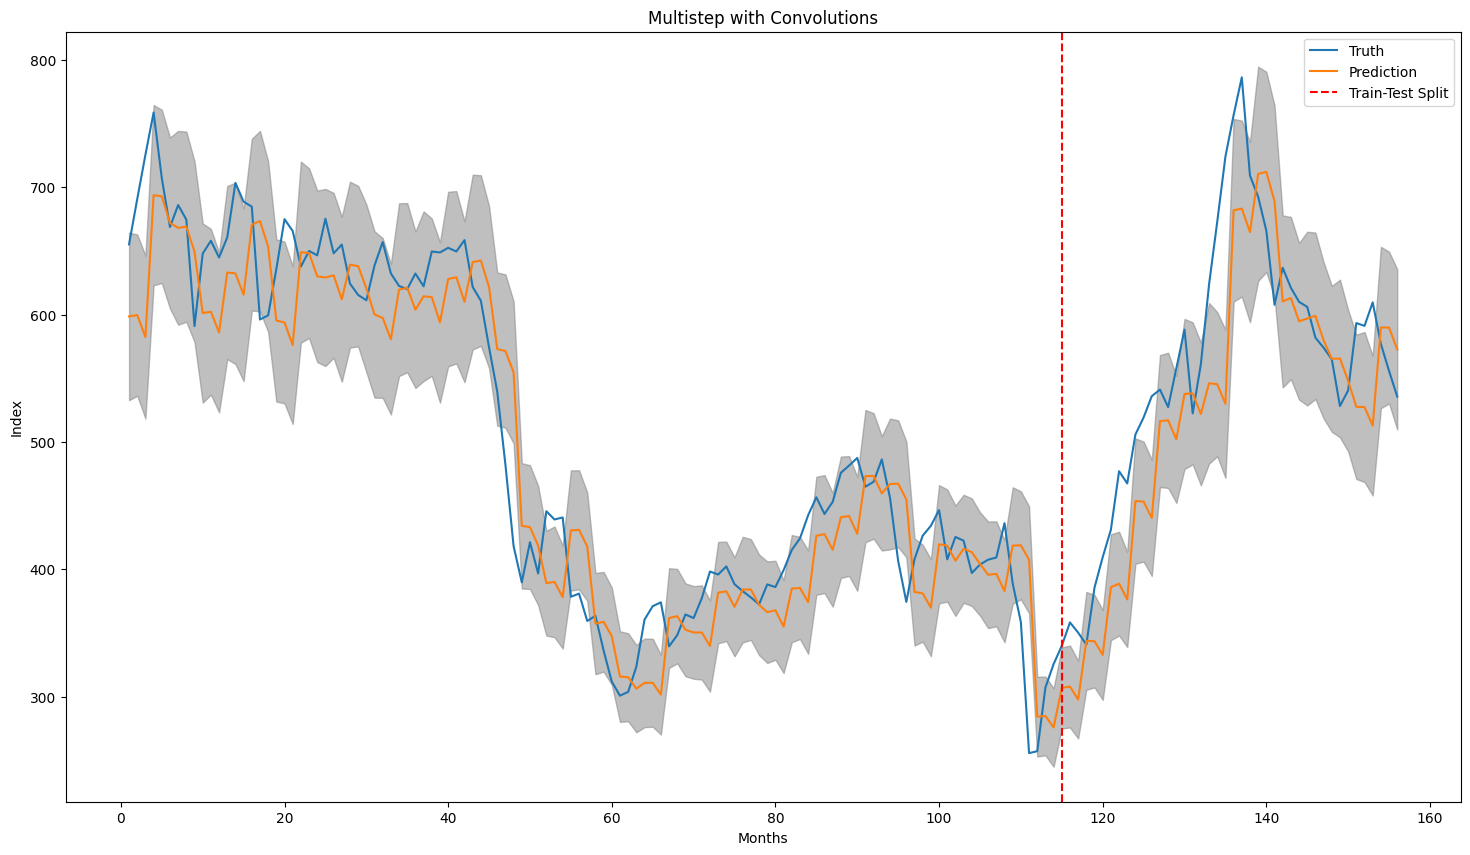

In [ ]:
plot_results(3, torch.cat(real).numpy().squeeze().flatten(), np.concatenate(pred_linear_multi, axis=0).flatten(), np.array(plus_error_linear_multi).squeeze().flatten(),
             np.array(minus_error_linear_multi).squeeze().flatten(), 'Multistep with Convolutions', train_x)

In [ ]:
mse_model = ((torch.cat(real).flatten().numpy()-np.concatenate(pred_cnn, axis =0))**2).sum()/len(pred_cnn)

print(np.sqrt(mse_model))

NameError: name 'naive_pred' is not defined

#MCMC One-STEP


In [ ]:
x_train,y_train= split_sequences(dataset, 3)
x_test, y_test = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],1,1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],1,1)).float()

In [ ]:
train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=32,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

In [ ]:
class BNN_linear_onestep(PyroModule):
    def __init__(self):
        super().__init__()
        assert in_dim > 0 and out_dim > 0
        self.linear_1 = PyroModule[nn.Linear](3,10)
        self.activation = PyroModule[nn.ReLU]()
        self.linear_2 = PyroModule[nn.Linear](10,30)
        self.linear_3 = PyroModule[nn.Linear](30,1)

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([1,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([1]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
pyro.clear_param_store()

model_mcmc_one = BNN_linear_onestep()

# define MCMC sampler
nuts_kernel = NUTS(model_mcmc_one, jit_compile=False)
mcmc_one = MCMC(nuts_kernel, num_samples=50)
mcmc_one.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [06:04,  3.65s/it, step size=1.22e-04, acc. prob=0.867]


In [ ]:
predictive = Predictive(model = model_mcmc_one, posterior_samples = mcmc_one.get_samples())

In [ ]:
preds_mcmc_one = predictive(x_test)

In [ ]:
minus_error_mcmc_one= (preds['obs'].mean(dim=0)-2*preds['obs'].std(dim=0)).numpy().flatten()
plus_error_mcmc_one= (preds['obs'].mean(dim=0)+2*preds['obs'].std(dim=0)).numpy().flatten()

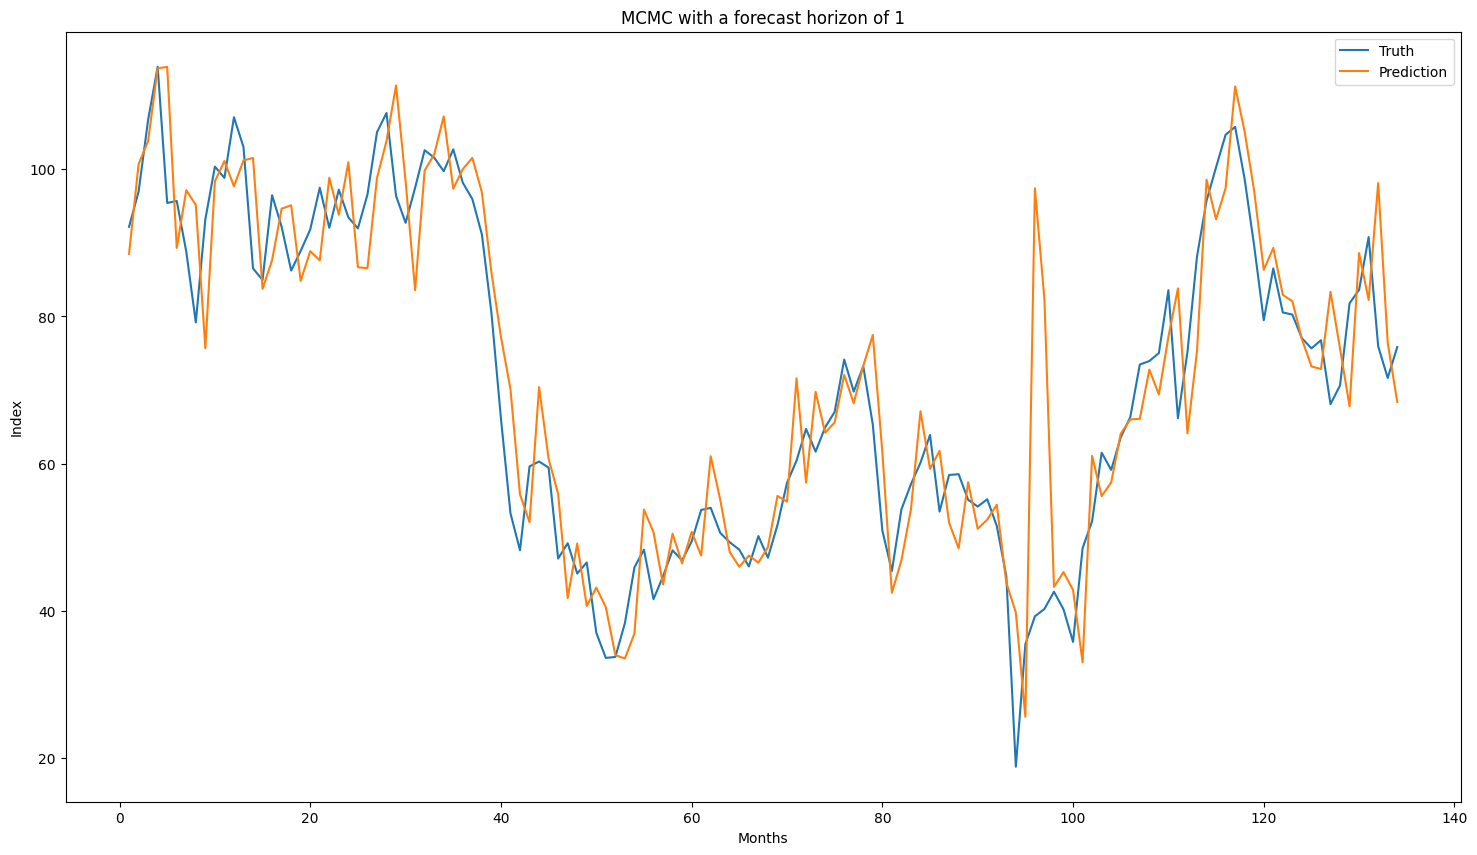

In [ ]:
plt.rcParams["figure.figsize"] = (18, 10)
x = np.arange(1, 135)

plt.plot(x, y_test.numpy().squeeze(), label='Truth')
plt.plot(x, preds['obs'].mean(dim=0), label='Prediction')


plt.xlabel('Months')
plt.ylabel('Index')
plt.title('MCMC with a forecast horizon of 1')
plt.legend()

plt.show()
#plt.savefig("CNN1.pdf")
#files.download("CNN1.pdf")


In [ ]:
mse_model = ((y_test.numpy().squeeze()-preds['obs'].mean(dim=0).numpy().flatten())**2).sum()/len(naive_pred)

print(np.sqrt(mse_model))

9.869968489568476 7.111625388678211


# MCMC 1 step BASF data


In [ ]:
from google.colab import files


uploaded = files.upload()

Saving eurusd_df_15min_2020-01-01_2024-02-06.csv to eurusd_df_15min_2020-01-01_2024-02-06.csv


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['eurusd_df_15min_2020-01-01_2024-02-06.csv'])).dropna().head(100)
print(df)

                datetime  bid_open  bid_high  bid_low  bid_close  ask_open  \
96   2020-01-02 00:00:00   1.12184   1.12186  1.12156    1.12157   1.12198   
97   2020-01-02 00:15:00   1.12154   1.12164  1.12151    1.12155   1.12168   
98   2020-01-02 00:30:00   1.12157   1.12169  1.12152    1.12167   1.12169   
99   2020-01-02 00:45:00   1.12169   1.12183  1.12169    1.12178   1.12181   
100  2020-01-02 01:00:00   1.12177   1.12225  1.12176    1.12221   1.12190   
..                   ...       ...       ...      ...        ...       ...   
191  2020-01-02 23:45:00   1.11701   1.11704  1.11696    1.11702   1.11715   
192  2020-01-03 00:00:00   1.11703   1.11731  1.11692    1.11724   1.11717   
193  2020-01-03 00:15:00   1.11722   1.11725  1.11707    1.11720   1.11735   
194  2020-01-03 00:30:00   1.11721   1.11725  1.11718    1.11721   1.11734   
195  2020-01-03 00:45:00   1.11722   1.11756  1.11721    1.11750   1.11734   

     ask_high  ask_low  ask_close  
96    1.12199  1.12167    1

In [ ]:
data_close = df['ask_close']
data_close

96     1.12168
97     1.12169
98     1.12181
99     1.12191
100    1.12234
        ...   
191    1.11716
192    1.11736
193    1.11732
194    1.11733
195    1.11762
Name: ask_close, Length: 100, dtype: float64

In [ ]:
#without training
data_list = []
data_test_list = []

data = data_close.values
test_data = data
data = data[:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)


In [ ]:
x_train,y_train= split_sequences(dataset, 3)
x_test, y_test = split_sequences(data_test_set,3)

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],1,1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],1,1)).float()

train_data = myDataset(x_train,y_train)
test_data = myDataset(x_test,y_test)
train_loader = torch.utils.data.DataLoader(train_data,batch_size=10,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data,batch_size=1,shuffle=False)

<ipython-input-45-3589b82bb2f5>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
<ipython-input-45-3589b82bb2f5>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train.reshape(y_train.shape[0],1,1)).float()
<ipython-input-45-3589b82bb2f5>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
<ipython-input-45-3589b82bb2f5>:4: UserWarning: To copy construct

In [ ]:
pyro.clear_param_store()

model = BNN_linear_onestep()

# define MCMC sampler
nuts_kernel = NUTS(model, jit_compile=False)
mcmc = MCMC(nuts_kernel, num_samples=50)
mcmc.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [03:20,  2.01s/it, step size=1.24e-04, acc. prob=0.332]


In [ ]:
predictive = Predictive(model=model, posterior_samples=mcmc.get_samples())
preds = predictive(x_test)

In [ ]:
minus_error= (preds['obs'].mean(dim=0)-2*preds['obs'].std(dim=0)).numpy().flatten()
plus_error= (preds['obs'].mean(dim=0)+2*preds['obs'].std(dim=0)).numpy().flatten()

ValueError: x and y must have same first dimension, but have shapes (97,) and (157,)

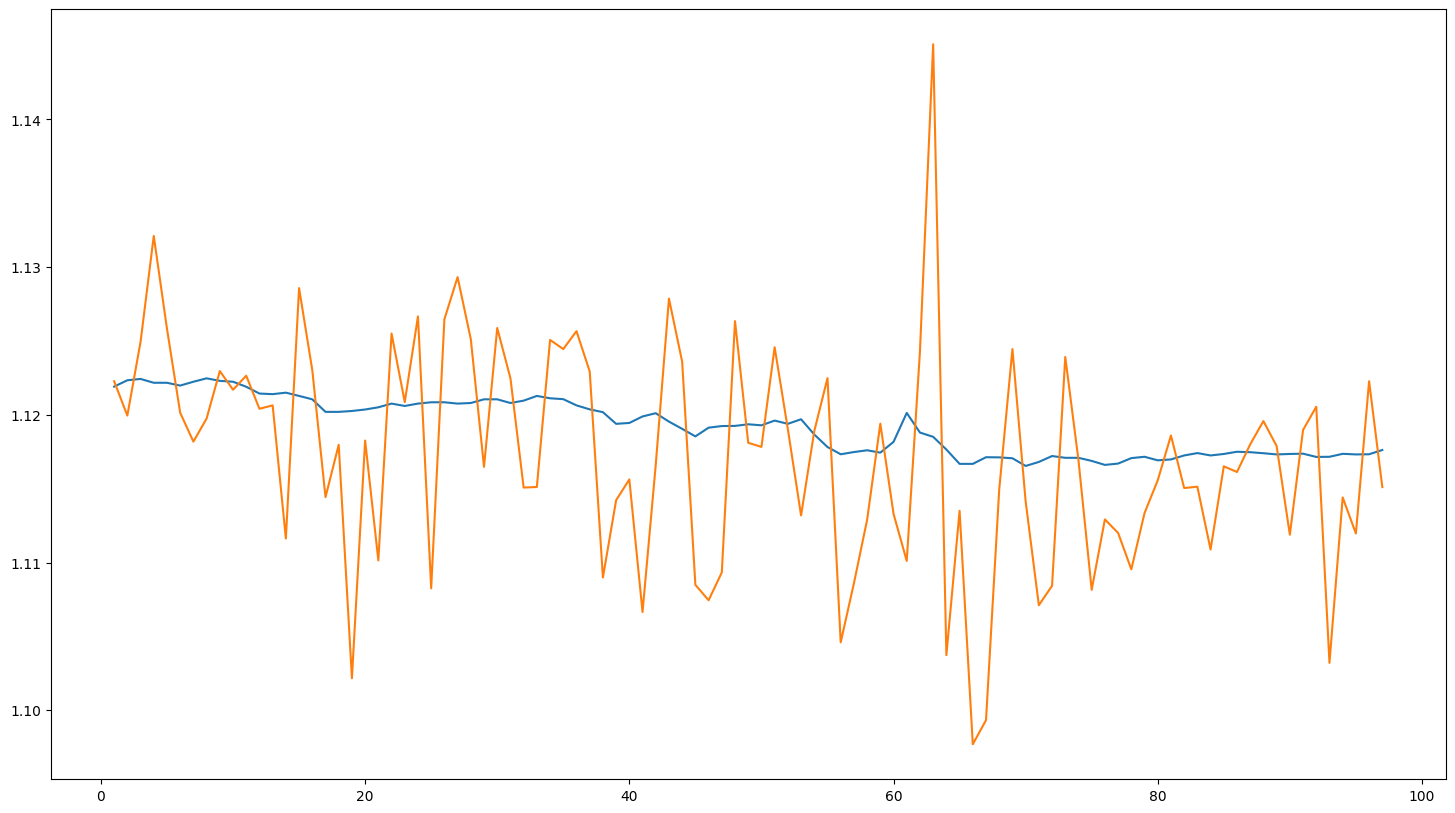

In [ ]:
plt.rcParams["figure.figsize"] = (18, 10)
x = np.arange(1, 98)

plt.plot(x, y_test.numpy().squeeze(), label='Truth')
plt.plot(x, preds['obs'].mean(dim=0), label='Prediction')

#plt.plot(x, np.vstack(plus_error_cnn).squeeze().tolist(), label='Plus Error')
#plt.plot(x, np.vstack(minus_error_cnn).squeeze().tolist(), label='Minus Error')
plt.plot(x, naive_pred, label= 'Naive model')
plt.fill_between(x, minus_error, plus_error, color='grey', alpha=0.5)
plt.axvline(x=120, linestyle='--', color='r', label='Test Set')


plt.xlabel('Months')
plt.ylabel('Index')
plt.title('MCMC with a forecast horizon of 1')
plt.legend()

plt.show()
#plt.savefig("CNN1.pdf")
#files.download("CNN1.pdf")

#MCMC Multistep

In [ ]:
data_list = []
data_test_list = []
df = yf.download('^SPGSCI', start="2010-09-23", end="2024-01-10", interval='1mo')
data_close = df.loc[:,'Adj Close']
data = data_close.values
test_data = data
data = data [:-40]
data_list.append(data)
data_test_list.append(test_data)
data_test_set = np.concatenate(data_test_list, axis=0)
dataset = np.concatenate(data_list, axis=0)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
train_x, train_y = multi_time(dataset, 3, 3)
test_x, test_y = multi_time(data_test_set, 3, 3)

In [ ]:
y_test = test_y[::3]
x_test = test_x[::3]
x_train = train_x[::3]
y_train = train_y[::3]

In [ ]:
x_train = torch.tensor(x_train.reshape(x_train.shape[0],x_train.shape[1],1)).float()
y_train = torch.tensor(y_train.reshape(y_train.shape[0],y_train.shape[1],1)).float()
x_test = torch.tensor(x_test.reshape(x_test.shape[0],x_test.shape[1],1)).float()
y_test = torch.tensor(y_test.reshape(y_test.shape[0],y_train.shape[1],1)).float()

In [ ]:
class BNN_linear_multistep(PyroModule):
    def __init__(self):
        super().__init__()
        assert in_dim > 0 and out_dim > 0
        self.linear_1 = PyroModule[nn.Linear](3,10)
        self.activation = PyroModule[nn.ReLU]()
        self.linear_2 = PyroModule[nn.Linear](10,30)
        self.linear_3 = PyroModule[nn.Linear](30,3)

        self.linear_1.weight = PyroSample(dist.Normal(0, 1).expand([10,3]).to_event(2))
        self.linear_1.bias = PyroSample(dist.Normal(0, 1).expand([10]).to_event(1))
        self.linear_2.weight = PyroSample(dist.Normal(0, 1).expand([30,10]).to_event(2))
        self.linear_2.bias = PyroSample(dist.Normal(0, 1).expand([30]).to_event(1))
        self.linear_3.weight = PyroSample(dist.Normal(0, 1).expand([3,30]).to_event(2))
        self.linear_3.bias = PyroSample(dist.Normal(0, 1).expand([3]).to_event(1))

    def forward(self, x, y = None):

        x = torch.flatten(x,1)
        x = self.activation(self.linear_1(x))
        x = self.activation(self.linear_2(x))
        x = self.activation(self.linear_3(x))
        mu = x
        sigma = pyro.sample("sigma", dist.Gamma(.5, 1))

        if y is not None:
            y = torch.flatten(y,1)

        with pyro.plate("data", x.shape[0]):

            obs = pyro.sample("obs", dist.Normal(mu, sigma * sigma).to_event(1), obs = y)
        return mu

In [ ]:
pyro.clear_param_store()

model_mcmc_multi = BNN_linear_multistep()

# define MCMC sampler
nuts_kernel = NUTS(model_mcmc_multi, jit_compile=False)
mcmc_multi = MCMC(nuts_kernel, num_samples=50)
mcmc_multi.run(x_train, y_train)

Sample: 100%|██████████| 100/100 [08:34,  5.15s/it, step size=1.67e-04, acc. prob=0.951]


In [ ]:
preds['obs'].mean(dim=0)

In [ ]:
predictive = Predictive(model = model_mcmc_multu, posterior_samples = mcmc_multi.get_samples())
preds_mcmc_multi = predictive(x_test)

In [ ]:
minus_error_mcmc_multi = (preds['obs'].mean(dim=0)-2*preds['obs'].std(dim=0)).numpy().flatten()
plus_error_mcmc_multi = (preds['obs'].mean(dim=0)+2*preds['obs'].std(dim=0)).numpy().flatten()

In [ ]:
((y_test.numpy().squeeze().flatten()-preds['obs'].mean(dim=0).numpy().squeeze().flatten())**2)

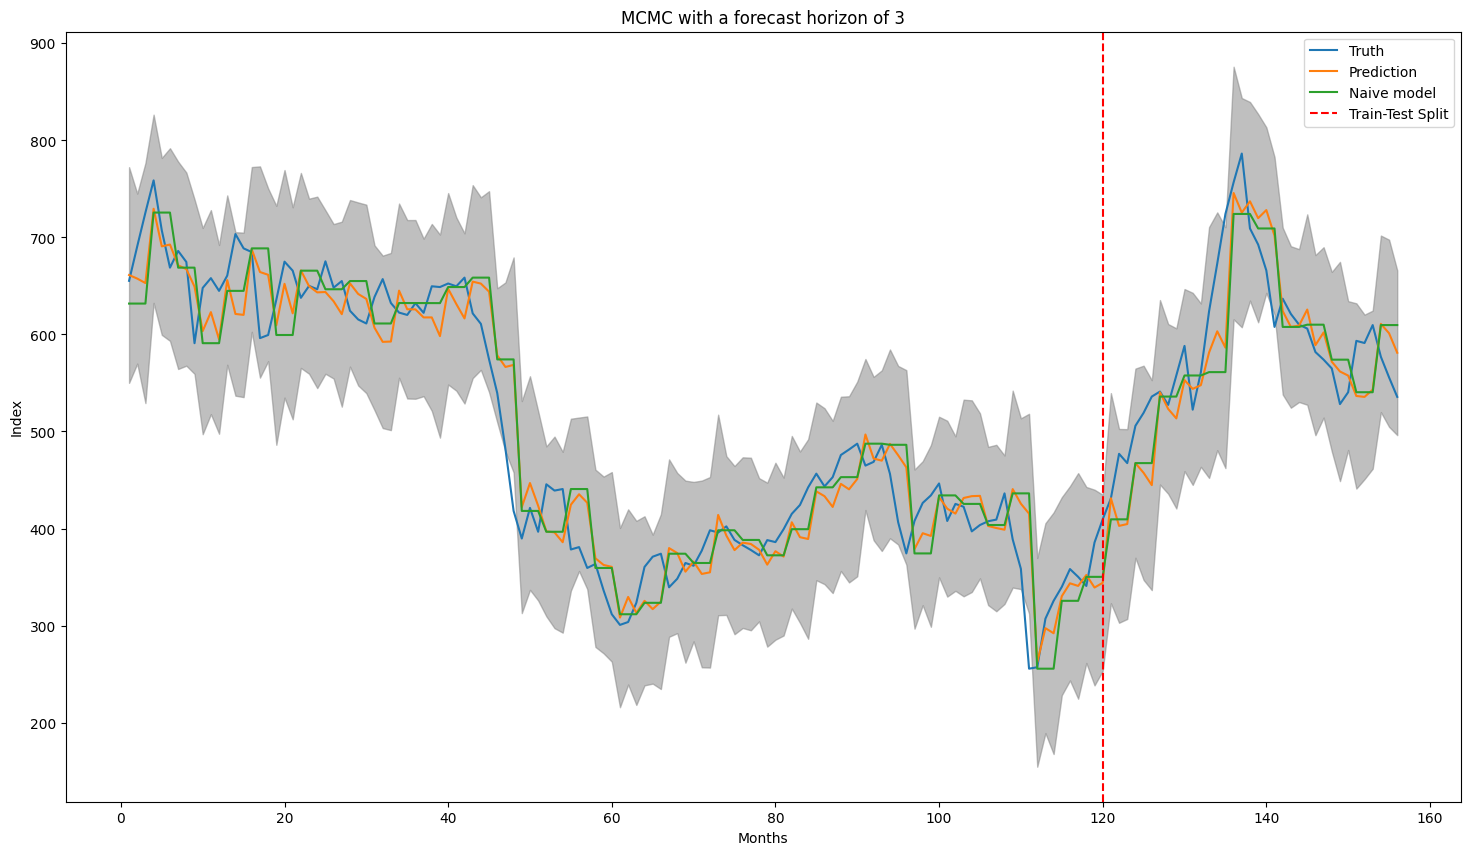

In [ ]:
plt.rcParams["figure.figsize"] = (18, 10)
x = np.arange(1, 157)

plt.plot(x, y_test.numpy().squeeze().flatten(), label='Truth')
plt.plot(x, preds['obs'].mean(dim=0).numpy().squeeze().flatten(), label='Prediction')

plt.plot(x, naive_pred, label= 'Naive model')
plt.fill_between(x, minus_error, plus_error, color='grey', alpha=0.5)
plt.axvline(x=120, linestyle='--', color='r', label='Train-Test Split')


plt.xlabel('Months')
plt.ylabel('Index')
plt.title('MCMC with a forecast horizon of 3')
plt.legend()

plt.show()
#plt.savefig("CNN1.pdf")
#files.download("CNN1.pdf")


In [ ]:
mse_model = ((y_test.numpy().squeeze().flatten()-preds['obs'].mean(dim=0).numpy().squeeze().flatten())**2).sum()/len(pred_cnn)

print(np.sqrt(mse_model))

75.6343088676337 83.04236079960373
